# Bakas et al. data: 280 genes and PCs for imaging features
## NB: t-SNE for all 704 subjects is also done here. rCCA is only done on 20 PCs.
### rCCA took approx. 6 hours to run 40x40. Did this two times, to search a larger and sanity check results

In [1]:
%%capture
import pandas as pd
import numpy as np

# Append system path to look for additional modules (needed for rcca)
import sys
sys.path.append("/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/Packages/")
sys.path.append("/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/kim_code/")

# Import self-build script
import radiogenomics as r

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import KFold

#Plotly 
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

import seaborn as sns
from scipy.stats.stats import pearsonr   
from sklearn.model_selection import train_test_split
import rcca
from scipy.spatial import distance_matrix

# Imports
import matplotlib.pyplot as plt
%matplotlib inline

path= '/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/Output_Data/Bakas57subjects/280genes_PCimg/'
PCs = [13, 19, 29, 38] # 70, 80, 90, 95%

# Data
### Gene data

In [2]:
df_TCGA = r.download_data("TCGA") 
df_TCGA = r.make_clean_df("TCGA", df_TCGA) # (393, 17k)
print(df_TCGA.shape)

(393, 17107)


In [2]:
# TCGA data
df_TCGA = r.download_data("TCGA") 
df_TCGA = r.make_clean_df("TCGA", df_TCGA) # (393, 17k)
print(df_TCGA.shape)

df_selected_genes = r.download_data("GENES") # (281,1), but not all in TCGA for some reason?
print(df_selected_genes.shape)

# 3 of the 281 genes are not in TCGA... so get the "correct" 278
list_genes = []
for gene in list(df_selected_genes['Selected Genes']):
    if gene in list(df_TCGA.columns):
        list_genes.append(gene)

df_TCGA = df_TCGA[list_genes]   # (393,278)
df_TCGA.shape

(393, 17107)
(281, 1)


(393, 278)

### Imaging Data (Bakas)

In [3]:
# Download and clean set up dataFrame:
df_TCIA = r.download_data("TCIA") 
df_TCIA = r.make_clean_df("TCIA", df_TCIA) # (102,704)
df_TCIA.shape

(102, 704)

### Matches

In [4]:
# Only Matches
matches = r.find_matches(df_TCGA, df_TCIA)
df_TCIA = df_TCIA.loc[matches,:].astype(float) # (57,712); need to turn into float
df_TCGA = df_TCGA.loc[matches,:].astype(float) # (57,278)
df_TCGA.shape

(57, 278)

# Analysis
## Correlation not tested here.
## PCA Reduction (Imaging features)
13 PCs = 70% explained<br>
19 PCs = 80 % explained<br>
29 PCs = 90 % explained<br>
36 PCs = 95 % explained<br>
Without this step, rCCA overfits way too much

In [ ]:
# Standardise X; it zero-scales pr. feature (so over a column. It works)
X_std = StandardScaler().fit_transform(df_TCIA.values)

# Apply PCA
nComp = 20 # Set number
pca = PCA(n_components=nComp) # Only first 10
pca.fit(X_std)

In [ ]:
# Check results
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

# Get plot
data_scree_and_cumul = r.plotly_scree(pca.explained_variance_ratio_, cum_var_exp)

# Plot layout
layout=Layout(
        autosize=False,
        width=800,
        height=600,
        yaxis=dict(
            YAxis(title='Explained variance'),
            range=[0,0.9]
        ),
        title='Explained variance by ' + str(nComp) + ' first principal components')

# Plot
fig_scree_and_cumul = Figure(data=data_scree_and_cumul, layout=layout)
py.iplot(fig_scree_and_cumul)

### Pick 19 principal components (explain 80%)

In [ ]:
nComp = 19 # Set number
pca = PCA(n_components=nComp)  
PCA_results = pca.fit_transform(X_std) # Apply reduction (57,20)
df_PCA_TCIA = pd.DataFrame(data=PCA_results, index=matches, columns=['PC %s' % i for i in range(1, nComp+1)])

### Look what is inside first Principal component
Very much Texture dominated... but also 500 out of 700 feature is texture

In [ ]:
df = pd.DataFrame(data=pca.components_[0], columns=['PC1'], index=df_TCIA.columns)
df['PC1 Squared'] = df['PC1']**2
df = df.sort_values(by=['PC1 Squared'], ascending=False)
display(df.head(5))

# rCCA

In [ ]:
# Split into test and training (img=X, genes=Y)
img_train, img_test, gene_train, gene_test = train_test_split(df_PCA_TCIA, # X
                                                    df_TCGA, # Y
                                                    test_size=0.2, 
                                                    random_state=42)
print("X_train:", img_train.shape)
print("X_test:", img_test.shape)
print("y_train:", gene_train.shape)
print("y_test:", gene_test.shape)

In [ ]:
# Save data for R
img_train.to_csv(path + "img_for_R_tuning")
gene_train.to_csv(path + "gene_for_R_tuning")

In [ ]:
# Load data from R - loadings
df_load_genes = pd.read_csv(path + 'R_loadings_genes')
df_load_genes = df_load_genes.set_index('Unnamed: 0', drop=True)
df_load_genes.index.name ='gene'
print(df_load_genes.shape)

df_load_img = pd.read_csv(path + 'R_loadings_img')
df_load_img = df_load_img.set_index('Unnamed: 0', drop=True)
df_load_img.index.name ='PC'
print(df_load_img.shape)

In [ ]:
# Compute test variates
rep_var_TCIA = np.matmul(img_test.values, df_load_img.values) # Values * weights
rep_var_TCIA = StandardScaler().fit_transform(rep_var_TCIA) # Need to standardise 

# Create variates TCGA
rep_var_TCGA = np.matmul(gene_test.values, df_load_genes.values)
rep_var_TCGA = StandardScaler().fit_transform(rep_var_TCGA) # Need to standardise 

# DataFrames
df_rep_var_TCIA = pd.DataFrame(data=rep_var_TCIA)
df_rep_var_TCGA = pd.DataFrame(data=rep_var_TCGA)

In [ ]:
# Correlation 
test_corr = [np.corrcoef(df_rep_var_TCIA.iloc[:,0], df_rep_var_TCGA.iloc[:,0])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,1], df_rep_var_TCGA.iloc[:,1])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,2], df_rep_var_TCGA.iloc[:,2])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,3], df_rep_var_TCGA.iloc[:,3])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,4], df_rep_var_TCGA.iloc[:,4])[0][1]]
test_corr

In [ ]:
# Plot just histogram
data_scree = r.plotly_scree_CCA(test_corr)

# Plot layout
layout=Layout(
        yaxis=YAxis(title='Canonical Correlation'),
        title='Canonical Correlation Analysis')

fig_scre = Figure(data=data_scree, layout=layout)
py.iplot(fig_scre)

## Look inside first canonical pair for genes and imaging respectively
## ONLY GENE SIDE!
I have not made it relative weights! i.e. I have not said w_i / w_sum

In [ ]:
# Sort
df_load_genes = df_load_genes.sort_values(by=['Y.1'], ascending=False) 
df = df_load_genes.drop(['Y.2', 'Y.3', 'Y.4', 'Y.5'], axis=1)
df.columns.name = 'Gene features importance'

# ONLY TOP 10
df_top = df.head(10)

# ONLY BOTTOM 10
df_bot = df.tail(10)

# Plot- Construct cmap
my_cmap = sns.light_palette("Navy", as_cmap=True)
my_cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot TOP POSITIVE WEIGHTS
plt.figure(figsize=(11,6))
plt.title('Gene feature weights in first canonical pair')
sns.heatmap(df_top, cmap=my_cmap, annot=True, fmt='.3f', linewidths=0.1)

In [ ]:
# Plot BOTTOM NEGATIVE WEIGHTS
plt.figure(figsize=(11,6))
plt.title('Gene feature weights in first canonical pair')
sns.heatmap(df_bot, cmap=my_cmap, annot=True, fmt='.3f', linewidths=0.1)

### New "test" of test set
Doesn't matter that there is overlap to the other... we don't estimate model performance from this, just to see the amount of variance

In [ ]:
d={}
kf = KFold(n_splits=5, random_state=None, shuffle=False)

i = 1
for tr_ind, tst_ind in kf.split(df_PCA_TCIA):
    img_train, img_test = df_PCA_TCIA.iloc[tr_ind,], df_PCA_TCIA.iloc[tst_ind]
    gene_train, gene_test = df_TCGA.iloc[tr_ind], df_TCGA.iloc[tst_ind]
    # Save data for R
    img_train.to_csv(path + "img_for_R_tuning_"+str(i))
    gene_train.to_csv(path + "gene_for_R_tuning_"+str(i))
    print(path + "img_for_R_tuning_"+str(i))
    d['img_test_'+str(i)] = img_test
    d['genes_test_'+str(i)] = gene_test
    i += 1

In [ ]:
# Load data from R - loadings
for i in range(1,6):
    df_lambd1 = pd.read_csv(path + 'R_optLambda1_' + str(i))
    d['lamda1_'+str(i)] = df_lambd1.loc[0,'x']
    
    df_lambd2 = pd.read_csv(path + 'R_optLambda2_' + str(i))
    d['lamda2_'+str(i)] = df_lambd2.loc[0,'x']
    
    df_load_genes = pd.read_csv(path + 'R_loadings_genes_'+str(i))
    df_load_genes = df_load_genes.set_index('Unnamed: 0', drop=True)
    df_load_genes.index.name ='gene'
    d['df_genes_'+str(i)] = df_load_genes
    print(d['df_genes_'+str(i)].shape)
    
    df_load_img = pd.read_csv(path + 'R_loadings_img_'+str(i))
    df_load_img = df_load_img.set_index('Unnamed: 0', drop=True)
    df_load_img.index.name ='PC'
    d['df_img_'+str(i)] = df_load_img
    print(d['df_img_'+str(i)].shape)

    # Compute test variates
    rep_var_TCIA = np.matmul(d['img_test_'+str(i)].values, d['df_img_'+str(i)].values) # Values * weights
    rep_var_TCIA = StandardScaler().fit_transform(rep_var_TCIA) # Need to standardise 

    # Create variates TCGA
    rep_var_TCGA = np.matmul(d['genes_test_'+str(i)].values, d['df_genes_'+str(i)].values)
    rep_var_TCGA = StandardScaler().fit_transform(rep_var_TCGA) # Need to standardise 

    # DataFrames
    df_rep_var_TCIA = pd.DataFrame(data=rep_var_TCIA)
    df_rep_var_TCGA = pd.DataFrame(data=rep_var_TCGA)
    
    # Correlation 
    test_corr = [np.corrcoef(df_rep_var_TCIA.iloc[:,0], df_rep_var_TCGA.iloc[:,0])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,1], df_rep_var_TCGA.iloc[:,1])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,2], df_rep_var_TCGA.iloc[:,2])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,3], df_rep_var_TCGA.iloc[:,3])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,4], df_rep_var_TCGA.iloc[:,4])[0][1]]
    d['test_corr_'+str(i)] = test_corr
    
    df_cv = pd.read_csv(path + 'R_rCCA_CV_'+str(i))
    df_cv.drop('Unnamed: 0', inplace=True, axis=1)
    d['max_cv_'+str(i)] = df_cv.max().max().round(4)

In [ ]:
indeces = [i for i in range(1,6)]
columns = ['test_corr_cc1', 'CV-score','Reg1','Reg2']

# Make data
data = []
for i in range(1,6):
    inner = []
    inner.append(d['test_corr_'+str(i)][0])
    inner.append(d['max_cv_'+str(i)])
    inner.append(d['lamda1_'+str(i)])
    inner.append(d['lamda2_'+str(i)])
    data.append(inner)

# Make DF
df_overview = pd.DataFrame(data=data, index=indeces, columns=columns)
df_overview

# CV HEATMAP

In [2]:
# Load 
df_cv = pd.read_csv(path +'R_rCCA_CV')
grid = pd.read_csv(path + 'R_rCCA_grid')

# Get index list, round to 4 decimals
index_list = list(grid['x'])
index_list = [ '%.4f' % elem for elem in index_list ]

# Drop current "index"
df_cv.drop('Unnamed: 0', inplace=True, axis=1)

# set rows and columns (symmetric)
df_cv.index = index_list
df_cv.columns = index_list

# Find max and related index/columns
max_score = df_cv.iloc[0,0]
index = list(df_cv.index)[0]
col = list(df_cv.columns)[0]

for index_row, row in df_cv.iterrows():
    for index_column, dist in row.iteritems():
        if df_cv.loc[index_row,index_column] > max_score:
            max_score = df_cv.loc[index_row,index_column]
            index = index_row
            col = index_column
print("Max_socre is: ", max_score)
print(df_cv.max().max().round(4))

Max_socre is:  0.20303091773769602
0.203


[Text(33,0.5,'Lambda1'), Text(0.5,15,'Lambda2')]

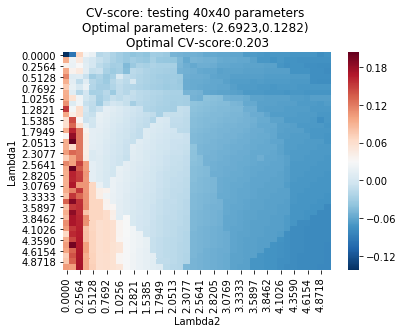

In [4]:
# MAKE SURE THAT INDEX/COL is CORRECT WITH LAMBDA1 / LAMBDA2
fig = sns.heatmap(df_cv, cmap="RdBu_r")
fig.set_title("CV-score: testing " + str(len(index_list))+"x" + str(len(index_list)) + " parameters \n" + 
             "Optimal parameters: (" +  index + "," + col +") \n" +
             "Optimal CV-score:" + str(max_score.round(4)))
fig.set(xlabel='Lambda2', ylabel='Lambda1')

# run rCCA with different levels of PCs

In [ ]:
# Create TCIA for R
pca_results = {}
dict_img_test = {}
dict_gene_test = {}

num_PCs = ['NO'] + PCs
for num in num_PCs:
    if num == 'NO':
        pca_results[num] = df_TCIA
    else: 
        pca_results[num] = r.run_pca(data=X_std, matches=df_TCIA.index, dimensions=num)
    
    # Split dataFrame
    img_train, img_test, gene_train, gene_test = train_test_split(pca_results[num], # X
                                                    df_TCGA, # Y
                                                    test_size=0.2, 
                                                    random_state=42)
    
    # Save
    img_train.to_csv(path + "img_for_R_tuning_PCs"+str(num))
    gene_train.to_csv(path + "gene_for_R_tuning_PCs"+str(num))
    
    dict_img_test[num] = img_test
    dict_gene_test[num] = gene_test

In [ ]:
# Load from R and perform computations
d={}

# For all
for num in num_PCs:
    df_lambd1 = pd.read_csv(path + 'R_optLambda1_PCs' + str(num))
    d['lamda1_PCs'+str(num)] = df_lambd1.loc[0,'x']
    
    df_lambd2 = pd.read_csv(path + 'R_optLambda2_PCs' + str(num))
    d['lamda2_PCs'+str(num)] = df_lambd2.loc[0,'x']
    
    df_load_genes = pd.read_csv(path + 'R_loadings_genes_PCs'+str(num))
    df_load_genes = df_load_genes.set_index('Unnamed: 0', drop=True)
    df_load_genes.index.name ='gene'
    d['df_genes_PCs'+str(num)] = df_load_genes
    
    df_load_img = pd.read_csv(path + 'R_loadings_img_PCs'+str(num))
    df_load_img = df_load_img.set_index('Unnamed: 0', drop=True)
    df_load_img.index.name ='PC'
    d['df_img_PCs'+str(num)] = df_load_img

    # Compute test variates, TCIA
    rep_var_TCIA = np.matmul(dict_img_test[num].values, d['df_img_PCs'+str(num)].values) # Values * weights
    rep_var_TCIA = StandardScaler().fit_transform(rep_var_TCIA) # Need to standardise 

    # Create variates TCGA
    rep_var_TCGA = np.matmul(dict_gene_test[num].values, d['df_genes_PCs'+str(num)].values)
    rep_var_TCGA = StandardScaler().fit_transform(rep_var_TCGA) # Need to standardise 

    # DataFrames
    df_rep_var_TCIA = pd.DataFrame(data=rep_var_TCIA)
    df_rep_var_TCGA = pd.DataFrame(data=rep_var_TCGA)
    
    # Correlation 
    test_corr = [np.corrcoef(df_rep_var_TCIA.iloc[:,0], df_rep_var_TCGA.iloc[:,0])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,1], df_rep_var_TCGA.iloc[:,1])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,2], df_rep_var_TCGA.iloc[:,2])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,3], df_rep_var_TCGA.iloc[:,3])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,4], df_rep_var_TCGA.iloc[:,4])[0][1]]
    d['test_corr_PCs'+str(num)] = test_corr
    
    if num != 'NO':
        df_cv = pd.read_csv(path + 'R_rCCA_CV_PCs'+str(num))
        df_cv.drop('Unnamed: 0', inplace=True, axis=1)
        d['max_cv_PCs'+str(num)] = df_cv.max().max().round(4)

In [ ]:
indeces = [i for i in num_PCs]
columns = ['cc1', 'cc2', 'cc3', 'cc4', 'cc5', 'CV-score','Reg1','Reg2']

# Make data
data = []
for i in num_PCs:
    inner = []
    inner.append(d['test_corr_PCs'+str(i)][0])
    inner.append(d['test_corr_PCs'+str(i)][1])
    inner.append(d['test_corr_PCs'+str(i)][2])
    inner.append(d['test_corr_PCs'+str(i)][3])
    inner.append(d['test_corr_PCs'+str(i)][4])
    if i != 'NO':
        inner.append(d['max_cv_PCs'+str(i)])
    else:
        inner.append('NONE')
    inner.append(d['lamda1_PCs'+str(i)])
    inner.append(d['lamda2_PCs'+str(i)])
    data.append(inner)

# Make DF
df_overview = pd.DataFrame(data=data, index=indeces, columns=columns)
df_overview

# Explore loadings inside the NO PCs model

In [ ]:
# Load data from R - loadings
df_load_genes = pd.read_csv(path + 'R_loadings_genes_PCsNO')
df_load_genes = df_load_genes.set_index('Unnamed: 0', drop=True)
df_load_genes.index.name ='gene'
print(df_load_genes.shape)

df_load_img = pd.read_csv(path + 'R_loadings_img_PCsNO')
df_load_img = df_load_img.set_index('Unnamed: 0', drop=True)
df_load_img.index.name ='PC'
print(df_load_img.shape)

# Compute test variates
rep_var_TCIA = np.matmul(dict_img_test['NO'].values, df_load_img.values) # Values * weights
rep_var_TCIA = StandardScaler().fit_transform(rep_var_TCIA) # Need to standardise 

# Create variates TCGA
rep_var_TCGA = np.matmul(dict_gene_test['NO'].values, df_load_genes.values)
rep_var_TCGA = StandardScaler().fit_transform(rep_var_TCGA) # Need to standardise 

# DataFrames
df_rep_var_TCIA = pd.DataFrame(data=rep_var_TCIA)
df_rep_var_TCGA = pd.DataFrame(data=rep_var_TCGA)


# Correlation 
test_corr = [np.corrcoef(df_rep_var_TCIA.iloc[:,0], df_rep_var_TCGA.iloc[:,0])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,1], df_rep_var_TCGA.iloc[:,1])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,2], df_rep_var_TCGA.iloc[:,2])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,3], df_rep_var_TCGA.iloc[:,3])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,4], df_rep_var_TCGA.iloc[:,4])[0][1]]
test_corr

### Genes

In [ ]:
# Sort
df_load_genes = df_load_genes.sort_values(by=['Y.1'], ascending=False) 
df = df_load_genes.drop(['Y.2', 'Y.3', 'Y.4', 'Y.5'], axis=1)
df.columns.name = ''

# ONLY TOP 10
df_top = df.head(5)

# ONLY BOTTOM 10
df_bot = df.tail(5)

# Plot- Construct cmap
my_cmap = sns.light_palette("navy", reverse=True)

# Plot TOP POSITIVE WEIGHTS
plt.figure(figsize=(11,1.5))
plt.title('Gene feature weights in first canonical pair')
sns.heatmap(df_top.T, cmap=my_cmap, annot=True, fmt='.3f', linewidths=0.1)

In [ ]:
# Plot BOTTOM NEGATIVE WEIGHTS
plt.figure(figsize=(11,1.5))
plt.title('Gene feature weights in first canonical pair')
sns.heatmap(df_bot.T, cmap=my_cmap, annot=True, fmt='.3f', linewidths=0.1)

### Img

In [ ]:
# Sort
df_load_img = df_load_img.sort_values(by=['X.1'], ascending=False) 
df = df_load_img.drop(['X.2', 'X.3', 'X.4', 'X.5'], axis=1)
df.columns.name = ''

# ONLY TOP 10
df_top = df.head(5)

# ONLY BOTTOM 10
df_bot = df.tail(5)

# Plot- Construct cmap
my_cmap =sns.light_palette("green", reverse=True)

# Plot TOP POSITIVE WEIGHTS
plt.figure(figsize=(11,1.5))
plt.title('Image feature weights in first canonical pair')
sns.heatmap(df_top.T, cmap=my_cmap, annot=True, fmt='.6f', linewidths=0.1)

In [ ]:
# Plot BOTTOM NEGATIVE WEIGHTS
plt.figure(figsize=(11,1.5))
plt.title('Image feature weights in first canonical pair')
sns.heatmap(df_bot.T, cmap=my_cmap, annot=True, fmt='.6f', linewidths=0.1)

# t-SNE 
### Generate data for Dash

In [5]:
# Add additional columns
# Get df of gene groups (number represents mutations)
df_gene_groups = r.df_gene_groups()
df_gene_groups = df_gene_groups.filter(list(df_TCIA.index), axis='index')

# Get gene data and prim vs. secondary + groupings to send more complete data to dash
df_TCGA = df_TCGA.filter(list(df_TCIA.index), axis='index')
df_prim_sec = r.get_prim_sec_from_idh1(df_TCGA)

# combine first
df_to_add = r.add_info(df_gene_groups, df_prim_sec.T.values.tolist(), df_prim_sec.columns)

# combine second
df_TCGA_FINAL = r.add_info(df_to_add, df_TCGA.T.values.tolist(), df_TCGA.columns)
df_TCGA_FINAL.shape

(57, 303)

In [6]:
X_std = StandardScaler().fit_transform(df_TCIA.values) 

In [7]:
# List of num_PCs to save
pca_results = {}

# The columns are just numbers (PCs)
for num in PCs:
    pca_results[num] = r.run_pca(data=X_std, matches=df_TCIA.index, dimensions=num)

In [8]:
run_no_PCA = False
if run_no_PCA:
    r.Dash_tsne_no_PCA(df_TCIA, df_to_add, path)

Dash_tsne_with_PCA = False
if Dash_tsne_with_PCA:
    for key, value in pca_results.items():
        r.Dash_tsne_with_PCA(value, df_to_add, path)

## t-SNE association algorithm

In [9]:
# For dataFrame
columns = ['Score', 
           't-SNE dimensions', 
           'Principal Components', 
           'Perplexity', 
           'Learning Rate', 
           'k', 
           'Threshold', 
           'Corrects', 
           'Total']

### Best result with k=5 + No_threshold

In [ ]:
# Get Results
k=5
this_PCs = ['NO'] + PCs
run=False  
if run:
    dict_opt_param, data = r.tsne_optimal_hyperparameters(ks=[k], 
                                                                         thresholds=[99999], 
                                                                         tsne_dims= r.tsne_dims, 
                                                                         PCs=this_PCs, 
                                                                         perps=r.perps, 
                                                                         learn_rates=r.learn_rates,
                                                                         subjects=list(df_TCGA_FINAL.index),
                                                                         path=path)
    np.save(path+"dict_opt_param_k="+str(k)+"_thres=NO"+"_allVariations", dict_opt_param)
    df = pd.DataFrame(data=data, columns=columns) 
    df.to_csv(path + "data_opt_param_k="+str(k)+"_thres=NO"+"_allVariations")
else: 
    dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres=NO"+"_allVariations"+".npy").item()
    df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres=NO"+"_allVariations")
    df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])

In [ ]:
### Best result for different Ks, No Threshold. 

In [ ]:
# Get Results
k=[1,2,3,4,5,6,7,9,10,12,15,18,20,25,29,35,45,52,56]
this_PCs = ['NO']+PCs
run=False 
if run:
    dict_opt_param, data = r.tsne_optimal_hyperparameters(ks=k, 
                                                                         thresholds=[99999], 
                                                                         tsne_dims= r.tsne_dims, 
                                                                         PCs=this_PCs, 
                                                                         perps=r.perps, 
                                                                         learn_rates=r.learn_rates,
                                                                         subjects=list(df_TCGA_FINAL.index),
                                                                         path=path)
    np.save(path+"dict_opt_param_k="+str(k)+"_thres=NO", dict_opt_param)
    df = pd.DataFrame(data=data, columns=columns) 
    df.to_csv(path + "data_opt_param_k="+str(k)+"_thres=NO")
else: 
    dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres=NO"+".npy").item()
    df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres=NO")
    df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])
print("k: ", dict_opt_param['k'])
print("Thres: ", dict_opt_param['thres'])

### Best result, k=5, different thresholds
thres >= 2 always.

In [ ]:
# Get Results
k=5
thres = [2, 3, 4,5,7,10,12,25,30,100]
this_PCs = ['NO']+PCs
run=False 
if run:
    dict_opt_param, data = r.tsne_optimal_hyperparameters(ks=[k], 
                                                                         thresholds=thres, 
                                                                         tsne_dims= r.tsne_dims, 
                                                                         PCs=this_PCs, 
                                                                         perps=r.perps, 
                                                                         learn_rates=r.learn_rates,
                                                                         subjects=list(df_TCGA_FINAL.index),
                                                                         path=path)
    np.save(path+"dict_opt_param_k="+str(k)+"_thres="+str(thres), dict_opt_param)
    df = pd.DataFrame(data=data, columns=columns) 
    df.to_csv(path + "data_opt_param_k="+str(k)+"_thres="+str(thres))
else: 
    dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres="+str(thres)+".npy").item()
    df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres="+str(thres))
    df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])

### Best result, k=5, No Threshold, Dim = 2

In [ ]:
# Get Results
k=5
run=False 
if run:
    dict_opt_param, data = r.tsne_optimal_hyperparameters(ks=[k], 
                                                                         thresholds=[99999], 
                                                                         tsne_dims= [2], 
                                                                         PCs=this_PCs, 
                                                                         perps=r.perps, 
                                                                         learn_rates=r.learn_rates,
                                                                         subjects=list(df_TCGA_FINAL.index),
                                                                         path=path)
    np.save(path+"dict_opt_param_k="+str(k)+"_thres=NO"+"_dim=2", dict_opt_param)
    df = pd.DataFrame(data=data, columns=columns) 
    df.to_csv(path + "data_opt_param_k="+str(k)+"_thres=NO"+"_dim=2")
else: 
    dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres=NO"+"_dim=2"+".npy").item()
    df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres=NO"+"_dim=2")
    df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])

# One complete run

In [11]:
# Get Results
k=[2,5,8,10]
thres = [2,3,4,5,10,20,100]
this_PCs = ['NO'] + PCs
run=False    
if run:
    dict_opt_param, data = r.tsne_optimal_hyperparameters(ks=k, 
                                                                         thresholds=thres, 
                                                                         tsne_dims= r.tsne_dims, 
                                                                         PCs=this_PCs, 
                                                                         perps=r.perps, 
                                                                         learn_rates=r.learn_rates,
                                                                         subjects=list(df_TCGA_FINAL.index),
                                                                         path=path)
    
    np.save(path+"DICT_OPT_PARAM", dict_opt_param)
    df = pd.DataFrame(data=data, columns=columns) 
    df.to_csv(path + "T-SNE_DF_DATA")
else: 
    dict_opt_param = np.load(path +"DICT_OPT_PARAM"+".npy").item()
    df = pd.read_csv(path+"T-SNE_DF_DATA")
    df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])
print("k: ", dict_opt_param['k'])
print("Thres: ", dict_opt_param['thres'])




best score is 0.625
Possible correct:  8
Correct:  3
Dim:  2
PC:  NO
Perp:  40
LearnRate:  100
k:  2
Thres:  2


### Neighbour matrix

In [ ]:
k=[2,5,8,10]
thres = [2,3,4,5,10,20,100]
k_thres_neighbours = {}
for this_k in k:
    for this_thres in thres:
        # Download genomic distance matrix from Paul (all genes)
        dist_matrix_gene = pd.read_csv(r.dist_matrix_path)
        dist_matrix_gene.set_index('Unnamed: 0', inplace=True, drop=True)

        dist_matrix_gene = dist_matrix_gene[matches]
        dist_matrix_gene = dist_matrix_gene.T[matches]

        # Identify k closests neighbours for each data point in Genomic Space; this is ground truth
        k_closest_genomic = r.k_closest(dist_matrix_gene, this_k)
        # Apply Threshold
        thres_k_closest_genomic = r.apply_threshold_on_k_closest(k_closest_genomic, dist_matrix_gene,
                                                                                   this_thres)
        
        k_thres_neighbours['k='+str(this_k)+'_thres='+str(this_thres)] = thres_k_closest_genomic

In [ ]:
np.save(path + 'k_thres_neighbours', k_thres_neighbours)

# Plots
### Cost plot: fixed k, no threshold, no PCA, dim=2 varying learning rate and perplexity, 

In [ ]:
# Get Results
k=5
dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres=NO"+"_dim=2"+".npy").item()
df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres=NO"+"_dim=2")
df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])
print("k: ", dict_opt_param['k'])
print("Thres: ", dict_opt_param['thres'])

In [ ]:
# Pick out data for axes
x = r.perps
y = r.learn_rates
X, Y = np.meshgrid(x, y)

# Can only plot two dimensions: Fix the other dimensions at optimal
# Fix PC and t-SNE dimensions at optimum, then have perp / learnRate on axes
df = df.loc[df['t-SNE dimensions'] == dict_opt_param['dim']] 
df = df.loc[df['Principal Components'] == str(dict_opt_param['pc'])]
pivot = pd.pivot_table(data=df, 
                       values='Score', 
                       index='Perplexity', 
                       columns='Learning Rate')

# Create Data
data = [
    Surface(
        z=pivot.T.values,
        x=X,
        y=Y
    )
]

# Beautify layout
layout = Layout(
    title='Surface Plot of Error for k=' + str(k) + "<br>" 
    + "NB: Can only show 2 dimensions, so PCs/t-SNE fixed." ,
    autosize=False,
    width=800,
    height=600,
    scene = dict(xaxis = dict(title='Perplexity'),
                yaxis = dict(title='Learning Rate'),
                zaxis = dict(title='Error'),
                ),
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )    
)

# Plot
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-surface')

### k Plot (no thres, PCA=opt, dim=opt, learnRate=opt, Perp=opt)

In [ ]:
# Get Results
k=[1,2,3,4,5,6,7,9,10,12,15,18,20,25,29,35,45,52]
dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres=NO"+".npy").item()
df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres=NO")
df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])
print("k: ", dict_opt_param['k'])
print("Thres: ", dict_opt_param['thres'])

In [ ]:
list_score = []
for k_val in k:
    df_segment = df.loc[df['k'] == k_val] # get only rows with specific k-value
    df_segment['col'] = [i for i in range(160)] # Re-set index to start from 0
    df_segment = df_segment.set_index('col', drop=True) # Make the column the index
    row = df_segment.iloc[df_segment['Score'].idxmin()] # Select max row
    list_score.append(row['Score']) # append value

X = k
Y = list_score
# Create a trace
trace = Scatter(
    x = X,
    y = Y,
)

layout = dict(title = 'Best performing hyperparameters for different k',
              yaxis = dict(title='Error'),
              xaxis = dict(title='k')
             )

# Plot
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='basic-line')


### Threshold plot (k=5, PCA=opt, dim=opt, learnRate=opt, Perp=opt)

In [ ]:
# Get Results
k=5
thres = [2, 3,4,5,7,10,12,15,20,25,30,50,100]
dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres="+str(thres)+".npy").item()
df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres="+str(thres))
df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])
print("k: ", dict_opt_param['k'])
print("Thres: ", dict_opt_param['thres'])

In [ ]:
list_score = []
for thres_val in thres:
    df_segment = df.loc[df['Threshold'] == thres_val] # get only rows with specific k-value
    df_segment['col'] = [i for i in range(800)] # Re-set index to start from 0
    df_segment = df_segment.set_index('col', drop=True) # Make the column the index
    row = df_segment.iloc[df_segment['Score'].idxmin()] # Select max row
    list_score.append(row['Score']) # append value

X = thres
Y = list_score
# Create a trace
trace = Scatter(
    x = X,
    y = Y,
)

layout = dict(title = 'Best performing hyperparameters for different thresholds',
              yaxis = dict(title='Error'),
              xaxis = dict(title='Threshold')
             )

# Plot
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='basic-line')